In [3]:
# from sframe import SFrame as sf

In [2]:
import pandas as pd
import json
# import matplotlib.pyplot as plt
# plt.style.use('ggplot')
from multiprocessing import Process, Pool
from threading import Thread
import time
import timeit
import numpy as np
# %matplotlib inline

# Nacteni dat

In [4]:
ndataset = "movielens_1m"

In [5]:
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/"+ndataset+"/items.json",'r') as f:
    items = json.loads(f.read())

with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/"+ndataset+"/properties.json",'r') as f:
    properties = json.loads(f.read())
    
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/"+ndataset+"/user.folds.json",'r') as f:
    user_folds = json.loads(f.read())
    
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/"+ndataset+"/users.int2str.json",'r') as f:
    users_int2str = json.loads(f.read())
    
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/"+ndataset+"/users.str2int.json",'r') as f:
    users_str2int = json.loads(f.read())
      
ratings = pd.read_csv("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/"+ndataset+"/ratings.csv",dtype = {'rating': np.float, 'itemId': np.str, 'userId':np.str} )

with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/"+ndataset+"/items.int2str.json",'r') as f:
    items_int2str = json.loads(f.read())
    
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/"+ndataset+"/items.str2int.json",'r') as f:
    items_str2int = json.loads(f.read())

# Faktorizace

In [6]:
import multiprocessing
import ctypes
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sparse_lg
import datetime
from math import sqrt

In [7]:
import platform
platform.architecture()

('64bit', 'ELF')

In [8]:
import numpy as np
from numpy.linalg import inv
# %load_ext line_profiler

In [43]:
class MatrixFactorization:
    def __init__(self, ratings, no_factors, relevant = .25, testset_amount = 0.2):
        self.Dataset = ratings
        self.Ratings = ratings.pivot_table(columns=['userId'],index=['itemId'],values='rating')
        self.Ratings_matrix = self.Ratings.values
        
        self.Testset = self.init_testset(testset_amount, relevant)
        
        self.Idx = np.isfinite(self.Ratings_matrix)
        self.Weights = np.isfinite(self.Ratings_matrix).astype(np.float64, copy=False)

        self.Ratings_matrix = np.nan_to_num(self.Ratings_matrix)
        self.Ratings_matrix_sparse = sp.csr_matrix(self.Ratings_matrix)
#         self.ratings_dict = dict(ratings.apply(lambda r:( (str(int(r.userId)),str(int(r.itemId))),{
#                                                                     'rating':r.rating,
#                                                                      }), axis=1).values)
        self.relevant = relevant
        self.number_of_obs_relevant_items = dict([(i,1+np.sum(self.Ratings_matrix[i,:] >= relevant)) for i in range(self.Ratings_matrix.shape[0]) ])

        self.testset_amount = testset_amount
        self.no_factors = no_factors
        self.Users = None
        self.Items = None
      
    def init(self):
        if(self.random_init): 
            user_shared_array_base = multiprocessing.Array(ctypes.c_double, np.random.rand(self.Ratings.shape[1]* self.no_factors), lock=False)
            user_shared_array = np.frombuffer(user_shared_array_base,dtype=float)    
            self.Users = user_shared_array.reshape(self.Ratings.shape[1], self.no_factors)
            
            
            item_shared_array_base = multiprocessing.Array(ctypes.c_double, np.random.rand(self.Ratings.shape[0] * self.no_factors), lock= False)
            item_shared_array = np.frombuffer(item_shared_array_base,dtype=float)
            self.Items = item_shared_array.reshape(self.Ratings.shape[0], self.no_factors)
            
    def init_optimizer(self):
        if(self.weights_mode == "AllRank"):
            self.Weights[self.Idx==False] = self.weight
            self.Weights_sparse = sp.csr_matrix(self.Weights)
            print("** Set weight: ",self.weight, " to missing ratings **")

        elif(self.weights_mode == "AllRank-pop"):
            print("AllRank-pop")
        
        elif(self.weights_mode == "MF-RMSE"):
            assert self.weight == 0, "Weight of missiong values MF-RMSE mode must be 0!"
            self.Weights_sparse = sp.csr_matrix(self.Weights)
            
          
        self.Ratings_matrix[self.Idx==False] = self.imputation_value
        self.Ratings_matrix_sparse = sp.csr_matrix(self.Ratings_matrix)
        print("** Surrogate missing rating values by imputation value: ", self.imputation_value, " **")

        
    def init_testset(self, testset_amount, relevant):
        ratings = self.Ratings_matrix
        Testset = {}
        
        for i_user in range(ratings.shape[1]):
            idx = np.where(ratings[:,i_user] >= relevant)[0]
            if(testset_amount):
                if(len(idx)):
                    random_choice = np.random.choice( idx, size = int(np.ceil(len(idx)*testset_amount)), replace = False)            
                    Testset[i_user] = {"indices": random_choice, "ratings": ratings[random_choice,i_user]}
                    ratings[random_choice,i_user] = np.nan
            else:
                Testset[i_user] = {"indices": idx, "ratings": ratings[idx,i_user]}
                
        return Testset
    '''
    ATOP
    '''
    
    def NRANKs_u(self, user, items):
        prediction = self.R_hat[:,user]
        ranks = np.argsort(prediction)
        N = len(prediction)
        nranks = np.array([np.where(ranks==item)[0][0] for item in items])/N
        return nranks

   
    
    def ATOP(self):
        atop = []
        RMSE = []
        for user, cont_id_rat in self.Testset.items():
            RMSE.extend(self.R_hat[cont_id_rat['indices'], user] - cont_id_rat['ratings'])
            nranks = self.NRANKs_u(user, cont_id_rat['indices'])
            atop.extend(nranks)
        
        return np.mean(atop), sqrt(np.mean((np.array(RMSE)**2)))
            
    
    def RECALL_u(self, u, K, beta):
        prediction = self.R_hat[:,u]
        T = self.Test_matrix
        idx = np.argsort(prediction)[::-1][:K]
        idx_relevant = np.where(T[:,u] == True)
    
        return np.sum(T[idx,u])/np.sum(T[:,u]), np.sum([1/(self.number_of_obs_relevant_items[i]**beta) for i in idx_relevant[0]]) #TODO IndexError: index 7591 is out of bounds for axis 0 with size 717


    
    def RECALL(self, K, beta):
        recall = 0
        for u in range(len(self.Users)):
            r, w = self.RECALL_u(u, K, beta)
            recall += r*w
        return recall
             
        
    '''
    RMSE
    '''  
    def RMSE(self, R, U, V, W):
        self.R_hat = np.dot(V,U.T)

        E = (R - (self.imputation_value + self.R_hat))
#         W_ = W[Idx] - self.weight
        return sqrt(((MFact.Weights==1).astype(np.float) * (E**2)).sum()/np.sum(W[W==1]) )
    
    '''
    OPTIMAZE PER FACTOR
    '''
    
    def compute_item_factor(self, batch):
        W, R, V = self.Weights, self.Ratings_matrix, self.Items
        lambda_, alfa, r_m = self.lambda_, self.alfa, self.imputation_value
        if(self.sparse):
            U = sp.csr_matrix(self.Users)
            UU = (MFact.weight*U.T).dot(U)
        else:
            U = self.Users

        if(self.opt_method == "solver"):
            if(self.sparse):
                for i in batch:
                    i_rated = MFact.Idx[i,:]
                    U_s = U[i_rated,:]
#                     print(i)
                    lM = sp.csr_matrix(R[i,:] - r_m).dot(sp.diags(W[i], 0)).dot(U)
                    if(not self.opt_lin):
                        rM = (U.T.dot(sp.diags(W[i], 0))).dot(U) + lambda_ * W[i].sum() * sp.eye(self.no_factors)
                    else:
                        rM = UU - (MFact.weight*U_s.T).dot(U_s) + U_s.T.multiply(sp.csr_matrix(np.ones((MFact.no_factors,1)).dot(MFact.Weights[i,i_rated].reshape(1, MFact.Weights[i,i_rated].shape[0])))).dot(U_s) + lambda_ * W[i].sum() * sp.eye(self.no_factors)

#                     V[i,:] = lM.dot(sparse_lg.inv(rM)).toarray()[0]
                    V[i,:] = sparse_lg.spsolve(rM,lM.T)
            elif(not self.sparse):
                for i in batch:
                    lM = np.dot(np.dot((R[i,:] - r_m),np.diag(W[i,:])),U)
                    rM = np.dot(np.dot(U.T,np.diag(W[i,:])),U) + lambda_ * W[i,:].sum() * np.eye(self.no_factors) #np.dot(np.trace(np.diag(W[i,:])),np.eye(self.no_factors))
                    V[i,:] = np.dot(lM, inv(rM))
#                     V[i,:] = np.linalg.solve(rM,lM)

        if(self.opt_method == "gradient-descent"):
            for i in batch:
                for c in range(50):
                    V[i] += -alfa * (np.dot((np.dot(V[i], U[Idx[i,:],:].T) - R[i,Idx[i,:]]), U[Idx[i,:],:]) + lambda_ * V[i]) #TODO pri AllRank je to spatne: Brat v uvahu vsechny hodnoceni 
        return
    
    def compute_user_factor(self, batch):
        W, R, U = self.Weights, self.Ratings_matrix, self.Users
        lambda_, alfa, r_m = self.lambda_, self.alfa, self.imputation_value
        if(self.sparse):
            V = sp.csr_matrix(self.Items)
            VV = (MFact.weight*V.T).dot(V)
        else:
            V = self.Items

 
        if(self.opt_method == "solver"):
            if(self.sparse):
                for u in batch:
                    u_rated = MFact.Idx[:,u]
                    V_s = V[u_rated,:]
                    
                    lM = sp.csr_matrix(R[:,u].T - r_m).dot(sp.diags(W[:,u], 0)).dot(V)
                    
                    if(not self.opt_lin):
                        rM = (V.T.dot(sp.diags(W[:,u], 0))).dot(V) + lambda_ * W[:,u].sum() * sp.eye(self.no_factors)
                    else:
                        rM = VV - (MFact.weight*V_s.T).dot(V_s) + V_s.T.multiply(sp.csr_matrix(np.ones((MFact.no_factors,1)).dot(MFact.Weights[u_rated,u].reshape(1, MFact.Weights[u_rated,u].shape[0])))).dot(V_s) + lambda_ * W[:,u].sum() * sp.eye(MFact.no_factors)

#                     U[u,:] = lM.dot(sparse_lg.inv(rM)).toarray()[0]
                    U[u,:] = sparse_lg.spsolve(rM,lM.T)
        
            elif(not self.sparse):
                for u in batch:
                    lM = np.dot(np.dot(R[:,u].T - r_m, np.diag(W[:,u])), V)
                    rM = np.dot(np.dot(V.T,np.diag(W[:,u])), V) + lambda_ * W[:,u].sum() * np.eye(self.no_factors) #np.dot(np.trace(np.diag(W[:,u]))
                    U[u,:] = np.dot(lM, inv(rM))
#                     U[u,:] = np.linalg.solve(rM,lM)

        if(self.opt_method == "gradient-descent"):
             for u in batch:
                for c in range(50):
                    U[u] += -alfa * (np.dot((np.dot(U[u], V[Idx[:,u],:].T) - R[Idx[:,u], u].T), V[Idx[:,u],:]) + lambda_* U[u] ) #TODO pri AllRank je to spatne: Brat v uvahu vsechny hodnoceni 
    
        return
    '''
    OPTIMIZE RMSE
    '''
    def optimize_rmse(self):
        self.init()
        self.init_optimizer()
        
        weighted_errors = []
        ATOPs = []
        
        step_item = int(np.ceil(len(self.Items)/float(self.no_process)))
        step_user = int(np.ceil(len(self.Users)/float(self.no_process)))
        
        item_range = [range(i,min(len(self.Items), i+step_item)) for i in range(0, len(self.Items), step_item)]
        user_range = [range(i,min(len(self.Users), i+step_user)) for i in range(0, len(self.Users), step_user)]
        print("Item range", item_range)
        print("User range", user_range)
        print("*******************************")
        print("Lambda: ", self.lambda_)
        print("Impute value: ", self.Ratings_matrix[self.Idx==False][0])
        print("Weight: ", self.Weights[self.Idx==False][0])
        print("*******************************")
        
        for ii in range(self.no_iterations):
            if(not ii % 1):
                weighted_errors.append(self.RMSE(self.Ratings_matrix, self.Users, self.Items, self.Weights))
                print('{}th iteration is completed'.format(ii))
                print("RMSE (TRAIN) ", weighted_errors[-1])
                
                atop, rmse = self.ATOP()
                ATOPs.append(atop)
                print("ATOP ", atop, " RMSE (TEST) ", rmse)

            #ITEMS                
            process = []
            for batch in item_range:
                p = Process(target = self.compute_item_factor, args = (batch,))
                p.daemon = True

                process.append(p)
                p.start()
            
            [p.join() for p in process]
                
            #USERS
            process = []
            for batch in user_range:
                p = Process(target = self.compute_user_factor, args = (batch,))
                p.daemon = True

                process.append(p)
                p.start()
            
            [p.join() for p in process]

        return weighted_errors, ATOPs

        
    def optimaze(self, no_iterations, loss_function="RMSE", opt_method="solver",  lambda_ = 0.001, alfa=0.00001, 
                 no_process = 1, random_init = True, weights_mode = "MF-RMSE", weight = 0, imputation_value = 0, sparse = False, beta = 0, K = 10, opt_lin = True):
        self.no_iterations = no_iterations
        self.loss_function = loss_function
        self.solve_opt_method = opt_method 
        self.lambda_ = lambda_
        self.alfa = alfa
        self.no_process = no_process
        self.no_iterations = no_iterations
        self.random_init = random_init
        self.weights_mode = weights_mode
        self.weight = weight
        self.imputation_value = imputation_value
        self.opt_method = opt_method
        self.sparse = sparse
        self.beta = beta 
        self.K = K
        self.opt_lin = opt_lin
        
        weighted_errors, ATOPs = self.optimize_rmse()
        
        self.plot_rmse(weighted_errors)
        return np.max(ATOPs)
    '''
    PLOT AND EXPLORE
    '''
    def plot_rmse(self, weighted_errors):
        plt.plot(np.log(weighted_errors), label="weighted error: "+str(weighted_errors[-1]))
        plt.ylabel("RMSE log scale")
        plt.xlabel("no iterations")

        plt.legend()
        plt.show()
        
    def explore(self):
        relevant = self.relevant 
        R = self.Ratings_matrix
        no_ratings = np.sum(self.Idx==True)
        no_missing = np.sum(self.Idx==False)
        no_all = no_ratings + no_missing
        
        sizes = [no_ratings, no_missing]
        labels = ["ratings", "missings"]
        colors = ['yellowgreen', 'lightskyblue']

        plt.pie(sizes, labels=labels,
                autopct='%1.1f%%', shadow=True, startangle=90, colors= colors)
        plt.axis('equal')
        plt.show()
        print("#{} rating, #{} missing".format(no_ratings, no_missing))
        print("Estimate offset w(m): ", no_ratings/no_missing)
        print("Avg of ratings: ", R[self.Idx].mean())
        
        no_relevant = np.sum(R[self.Idx]>=relevant)
        no_irelevant = np.sum(R[self.Idx]<relevant)
        labels = ["relevant", "irelevenat"]

        sizes = [no_relevant, no_irelevant]
        colors = ['lightskyblue', 'lightcoral']
        plt.pie(sizes, labels=labels,
                autopct='%1.1f%%', shadow=True, startangle=90, colors= colors)
        plt.axis('equal')
        plt.show()
        
        print("#{} relevant, #{} irelevant".format(no_relevant, no_irelevant))

        items_popularity = np.sort(list(MFact.number_of_obs_relevant_items.values()))[::-1]
#         plt.bar(range(len(items_popularity)),items_popularity)
        plt.xticks([])
        plt.ylabel("# of item rating marked as relevant")
        plt.xlabel("item")
        plt.plot(items_popularity,'_')
        plt.show()
        
        plt.hist(MFact.Dataset['rating'].values,bins = len(set(MFact.Dataset['rating'])))
        plt.xlabel("rating")
        plt.show()

In [44]:
# %lprun -f MFact.rmse_optimalization MFact.rmse_optimalization(0.001, 0.0001, 5)

In [45]:
ifold = 0
dataset = ratings[~ratings.userId.isin(user_folds[ifold])]

In [48]:
MFact = MatrixFactorization(dataset[:].copy(), 50, relevant = 1., testset_amount = 0.2)
for  i in range(MFact.Weights.shape[0]):
    if(not np.sum(MFact.Weights[i,:])):
        print(np.sum(MFact.Weights[i,:]))

In [49]:
MFact.optimaze(no_iterations = 6, opt_method="solver",  lambda_ = 0.02, no_process = 7, weights_mode = "AllRank", weight = 0.05, opt_lin = True, imputation_value = -0.5 , random_init = True, sparse = True, beta= 0.0, K = 20)


** Set weight:  0.05  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.02
Impute value:  -0.5
Weight:  0.05
*******************************
0th iteration is completed
RMSE (TRAIN)  11.876109618959843
ATOP  0.50187196667  RMSE (TEST)  11.642501700762635
1th iteration is completed
RMSE (TRAIN)  0.6706237824452365
ATOP  0.897065338575  RMSE (TEST)  0.6425848041376033
2th iteration is completed
RMSE (TRAIN)  0.4827147524375518
ATOP  0.931744190529  RMSE (TEST)  0.393622969960265
3th iteration is completed
RMSE (TRAIN)  0.44882427064317276
ATOP  0.936448341835  RMSE (TEST)  0.36602324148639276
4th iteration is completed
RMSE (TRAIN)  0

NameError: name 'plt' is not defined

In [89]:
def save_results(model, ndataset, ifold):
    no_iteration, no_factors, lambda_ = MFact.no_iterations, MFact.no_factors, MFact.lambda_
    
    with open(ndataset+str(ifold)+"_model_k"+str(no_factors)+"_l"+str(lambda_)+"_t"+str(no_iteration)+".txt", 'w') as f:
        f.write("m "+str(model.Users.shape[0])+"\n")
        f.write("n "+str(model.Items.shape[0])+"\n")
        f.write("k "+str(no_factors)+"\n")
        for idx, laten_vec in enumerate(model.Users):
            idf = users_str2int[MFact.Ratings.columns[idx]]
            f.write("p"+str(idf)+" "+' '.join(list(laten_vec.astype('str')))+"\n")
        for idx, laten_vec in enumerate(model.Items):
            idf = items_str2int[MFact.Ratings.index[idx]]
            f.write("q"+str(idf)+" "+' '.join(list(laten_vec.astype('str')))+"\n")
        

In [90]:
save_results(MFact, ndataset, ifold)

In [113]:
MFact.Ratings - MFact.R_hat

userId,100,1000,1001,1002,1003,1004,1005,1007,1008,1009,...,99,990,991,992,993,995,996,997,998,999
itemId,,,,,,,,,,,,,,,,,,,,,
1,NaN,-0.094838,-0.315688,NaN,NaN,-0.123140,NaN,NaN,-0.193125,NaN,...,-0.831081,-0.318452,NaN,NaN,NaN,NaN,-0.380129,-0.360355,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,-1.211645,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.751419
1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.164572
1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
users_str2int['100']

99

In [109]:
MFact.R_hat[1,5]

0.71164466368119017

In [118]:
len(set(ratings['userId']))

6040

In [119]:
len(set(dataset['userId']))

5436

In [120]:
MFact.Users.shape

(5436, 50)

In [114]:
MFact.Users[0]

array([ 0.09259408,  0.1254056 ,  0.04018955,  0.0521781 ,  0.12859698,
        0.09363232, -0.07246795,  0.09022057,  0.12698109,  0.11428258,
        0.14286022,  0.09868892,  0.30483819,  0.15140335,  0.12784042,
        0.04289642,  0.02017891,  0.07399156, -0.00040022,  0.04617785,
       -0.02910201,  0.05874377,  0.05318572,  0.15780303, -0.04674199,
        0.06102327,  0.12364245,  0.13157719,  0.08138641,  0.00621835,
        0.10331052,  0.01306375,  0.03234738, -0.1030814 ,  0.11440982,
        0.04674319,  0.02467404,  0.09942146,  0.09522871, -0.05215715,
        0.02082338,  0.08885887,  0.12551767,  0.12065275, -0.03503891,
        0.10840625,  0.00122049, -0.03809456,  0.12008514,  0.03580035])

In [112]:
np.sum(MFact.Items[1]*MFact.Users[5])

0.71868933763322473

** Set weight:  0  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.01
Impute value:  -0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  11.854756088916309
ATOP  0.49823884908  RMSE (TEST)  11.60382636362778
1th iteration is completed
RMSE (TRAIN)  0.4081566745509856
ATOP  0.76989610228  RMSE (TEST)  0.2843802070485453
2th iteration is completed
RMSE (TRAIN)  0.33211519385390637
ATOP  0.804063788808  RMSE (TEST)  0.3006344559601785
3th iteration is completed
RMSE (TRAIN)  0.30787667901617904
ATOP  0.81777658123  RMSE (TEST)  0.30657444630837166
4th iteration is completed
RMSE (TRAIN)  0.2959

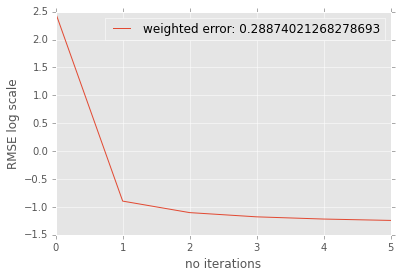

** Set weight:  0.02  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.01
Impute value:  -0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  11.833016143962322
ATOP  0.501289855678  RMSE (TEST)  11.563800454499367
1th iteration is completed
RMSE (TRAIN)  0.5008506001779102
ATOP  0.887430612464  RMSE (TEST)  0.41641418493916044
2th iteration is completed
RMSE (TRAIN)  0.39054234325924186
ATOP  0.908092244364  RMSE (TEST)  0.35459443754643233
3th iteration is completed
RMSE (TRAIN)  0.3634041478413421
ATOP  0.915118576577  RMSE (TEST)  0.3427582009444303
4th iteration is completed
RMSE (TRAIN)

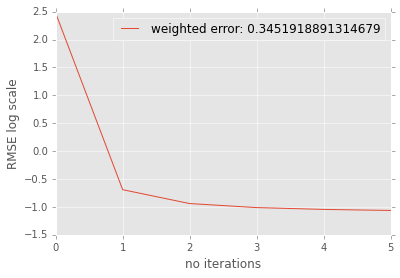

** Set weight:  0.05  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.01
Impute value:  -0.5
Weight:  0.05
*******************************
0th iteration is completed
RMSE (TRAIN)  11.95473876313486
ATOP  0.513979174493  RMSE (TEST)  11.68201560252569
1th iteration is completed
RMSE (TRAIN)  0.585824868679627
ATOP  0.896432081367  RMSE (TEST)  0.5323943281983208
2th iteration is completed
RMSE (TRAIN)  0.43913332808455213
ATOP  0.919451035494  RMSE (TEST)  0.40366787496169815
3th iteration is completed
RMSE (TRAIN)  0.4114597933532198
ATOP  0.925788349065  RMSE (TEST)  0.3813180356055152
4th iteration is completed
RMSE (TRAIN)  0.

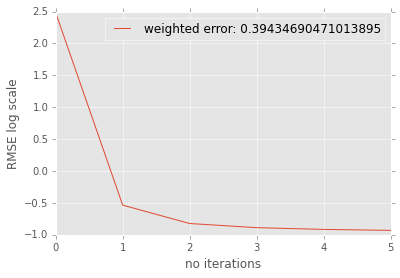

** Set weight:  0.08  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.01
Impute value:  -0.5
Weight:  0.08
*******************************
0th iteration is completed
RMSE (TRAIN)  11.797662306112626
ATOP  0.491753974792  RMSE (TEST)  11.513417282742882
1th iteration is completed
RMSE (TRAIN)  0.657786239034355
ATOP  0.8984822485  RMSE (TEST)  0.6289831889245169
2th iteration is completed
RMSE (TRAIN)  0.473561714651386
ATOP  0.923736729811  RMSE (TEST)  0.43716282638442916
3th iteration is completed
RMSE (TRAIN)  0.44455008987790606
ATOP  0.929484918016  RMSE (TEST)  0.4106619581152673
4th iteration is completed
RMSE (TRAIN)  0.4

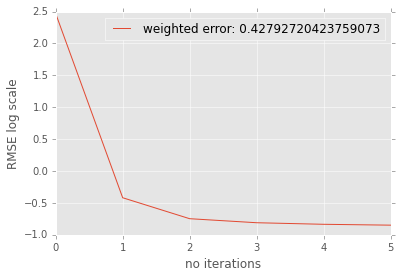

** Set weight:  0.1  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.01
Impute value:  -0.5
Weight:  0.1
*******************************
0th iteration is completed
RMSE (TRAIN)  11.908857114276275
ATOP  0.513409968435  RMSE (TEST)  11.664436023237139
1th iteration is completed
RMSE (TRAIN)  0.6841852670287374
ATOP  0.896599441434  RMSE (TEST)  0.6649441589673669
2th iteration is completed
RMSE (TRAIN)  0.4911021877055244
ATOP  0.926789680988  RMSE (TEST)  0.4505695255714089
3th iteration is completed
RMSE (TRAIN)  0.4618394849621793
ATOP  0.931585511619  RMSE (TEST)  0.42558762515519055
4th iteration is completed
RMSE (TRAIN)  0.

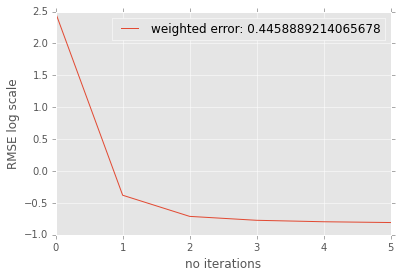

** Set weight:  0.3  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.01
Impute value:  -0.5
Weight:  0.3
*******************************
0th iteration is completed
RMSE (TRAIN)  11.856753573892961
ATOP  0.500831225454  RMSE (TEST)  11.606382286274554
1th iteration is completed
RMSE (TRAIN)  0.8321816286723475
ATOP  0.890902658301  RMSE (TEST)  0.8652528989014326
2th iteration is completed
RMSE (TRAIN)  0.6072904238066503
ATOP  0.93119879925  RMSE (TEST)  0.5584643621465539
3th iteration is completed
RMSE (TRAIN)  0.5760556770289472
ATOP  0.935126507934  RMSE (TEST)  0.5334402414523693
4th iteration is completed
RMSE (TRAIN)  0.56

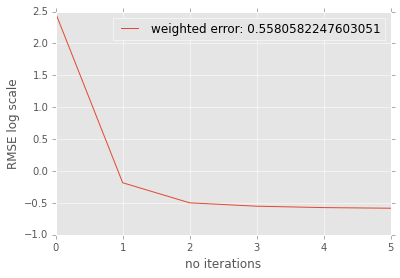

** Set weight:  0.5  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.01
Impute value:  -0.5
Weight:  0.5
*******************************
0th iteration is completed
RMSE (TRAIN)  11.908518483122501
ATOP  0.512326541184  RMSE (TEST)  11.671900452676546
1th iteration is completed
RMSE (TRAIN)  0.8886944169973615
ATOP  0.892336160284  RMSE (TEST)  0.9395602916307898
2th iteration is completed
RMSE (TRAIN)  0.6695730892022018
ATOP  0.925393422744  RMSE (TEST)  0.6362641062360013
3th iteration is completed
RMSE (TRAIN)  0.6464038730325016
ATOP  0.931246984403  RMSE (TEST)  0.6108427634530458
4th iteration is completed
RMSE (TRAIN)  0.6

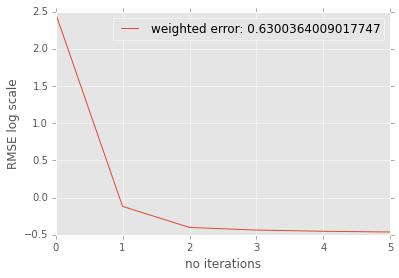

** Set weight:  0  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.01
Impute value:  -0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  12.374055569534715
ATOP  0.496486732876  RMSE (TEST)  11.57341699828298
1th iteration is completed
RMSE (TRAIN)  0.42619720349980783
ATOP  0.727264187311  RMSE (TEST)  0.7395961191164286
2th iteration is completed
RMSE (TRAIN)  0.3297010959153948
ATOP  0.783440139336  RMSE (TEST)  0.6251788367740063
3th iteration is completed
RMSE (TRAIN)  0.3037142851359529
ATOP  0.801459189366  RMSE (TEST)  0.5958278763361241
4th iteration is completed
RMSE (TRAIN)  0.29197457253038556
ATOP  0.808880422646  RMSE (TEST)  0.58167084751183

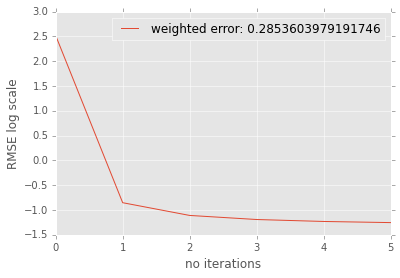

** Set weight:  0.02  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.01
Impute value:  -0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  12.382774410204876
ATOP  0.499485286349  RMSE (TEST)  11.621807099189484
1th iteration is completed
RMSE (TRAIN)  0.4861346307069825
ATOP  0.87076435176  RMSE (TEST)  0.8353342542727903
2th iteration is completed
RMSE (TRAIN)  0.3654860748804482
ATOP  0.906342628333  RMSE (TEST)  0.6842212507494664
3th iteration is completed
RMSE (TRAIN)  0.34585656324284614
ATOP  0.914375204425  RMSE (TEST)  0.6598985761849236
4th iteration is completed
RMSE (TRAIN)  0.3382448260424997
ATOP  0.917333957164  RMSE (TEST)  0.65040592865

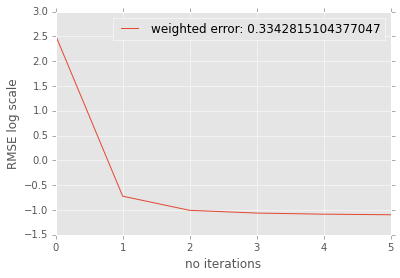

** Set weight:  0.05  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.01
Impute value:  -0.5
Weight:  0.05
*******************************
0th iteration is completed
RMSE (TRAIN)  12.37253250927972
ATOP  0.500028467879  RMSE (TEST)  11.614316134691522
1th iteration is completed
RMSE (TRAIN)  0.5269334077849084
ATOP  0.884870511051  RMSE (TEST)  0.894033919358642
2th iteration is completed
RMSE (TRAIN)  0.40058181190299447
ATOP  0.921474963438  RMSE (TEST)  0.7264251674792623
3th iteration is completed
RMSE (TRAIN)  0.3857783543553522
ATOP  0.927381287586  RMSE (TEST)  0.708593098494531
4th iteration is completed
RMSE (TRAIN)  0.3805848921613999
ATOP  0.929465472225  RMSE (TEST)  0.7020326518212

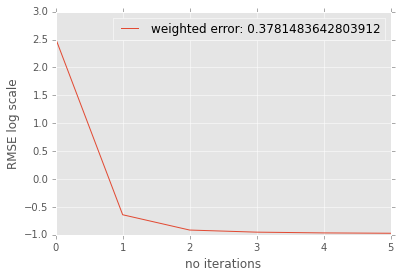

** Set weight:  0.08  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.01
Impute value:  -0.5
Weight:  0.08
*******************************
0th iteration is completed
RMSE (TRAIN)  12.314570072285745
ATOP  0.500087493429  RMSE (TEST)  11.58252646468433
1th iteration is completed
RMSE (TRAIN)  0.553209864552946
ATOP  0.890248421106  RMSE (TEST)  0.9331964906127506
2th iteration is completed
RMSE (TRAIN)  0.42848291192830984
ATOP  0.927918850041  RMSE (TEST)  0.757059576495186
3th iteration is completed
RMSE (TRAIN)  0.41469142704931633
ATOP  0.931489217076  RMSE (TEST)  0.746434319415316
4th iteration is completed
RMSE (TRAIN)  0.41070538314364335
ATOP  0.933012971516  RMSE (TEST)  0.742648531117

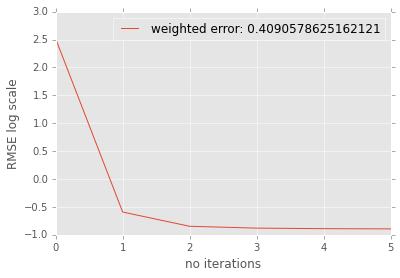

** Set weight:  0.1  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.01
Impute value:  -0.5
Weight:  0.1
*******************************
0th iteration is completed
RMSE (TRAIN)  12.413250875625945
ATOP  0.505258741454  RMSE (TEST)  11.66890496970669
1th iteration is completed
RMSE (TRAIN)  0.5649988449450627
ATOP  0.891613029432  RMSE (TEST)  0.9535160168628619
2th iteration is completed
RMSE (TRAIN)  0.4448007433804667
ATOP  0.930418606368  RMSE (TEST)  0.7767709976563143
3th iteration is completed
RMSE (TRAIN)  0.4301982399558816
ATOP  0.933052235597  RMSE (TEST)  0.7683417839707863
4th iteration is completed
RMSE (TRAIN)  0.4268442605505318
ATOP  0.934464864923  RMSE (TEST)  0.76549209993093

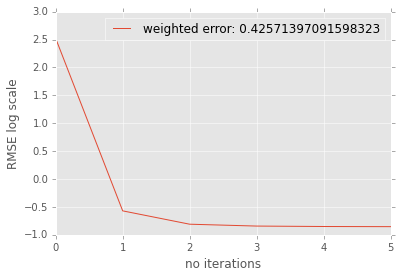

** Set weight:  0.3  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.01
Impute value:  -0.5
Weight:  0.3
*******************************
0th iteration is completed
RMSE (TRAIN)  12.294468427198886
ATOP  0.48953720522  RMSE (TEST)  11.522162242892062
1th iteration is completed
RMSE (TRAIN)  0.6419587074737417
ATOP  0.889957870696  RMSE (TEST)  1.0772662186049748
2th iteration is completed
RMSE (TRAIN)  0.5542541617605824
ATOP  0.931327640237  RMSE (TEST)  0.9209862456827519
3th iteration is completed
RMSE (TRAIN)  0.5393342149401948
ATOP  0.935762580994  RMSE (TEST)  0.9128659735518293
4th iteration is completed
RMSE (TRAIN)  0.5341678664514967
ATOP  0.936709458391  RMSE (TEST)  0.91643045149054

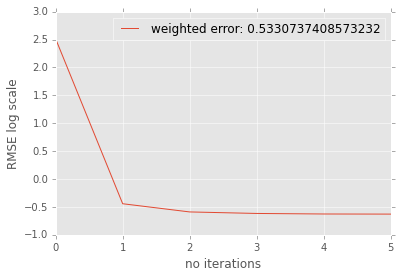

** Set weight:  0.5  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.01
Impute value:  -0.5
Weight:  0.5
*******************************
0th iteration is completed
RMSE (TRAIN)  12.400427519429794
ATOP  0.502708558657  RMSE (TEST)  11.666065516094173
1th iteration is completed
RMSE (TRAIN)  0.6789201912139656
ATOP  0.889297345186  RMSE (TEST)  1.1373594483916099
2th iteration is completed
RMSE (TRAIN)  0.6173374673868768
ATOP  0.923670822472  RMSE (TEST)  1.0235127031089077
3th iteration is completed
RMSE (TRAIN)  0.607296593982761
ATOP  0.931199272768  RMSE (TEST)  1.0120673749316318
4th iteration is completed
RMSE (TRAIN)  0.6043505160230392
ATOP  0.933441580724  RMSE (TEST)  1.01297058102017

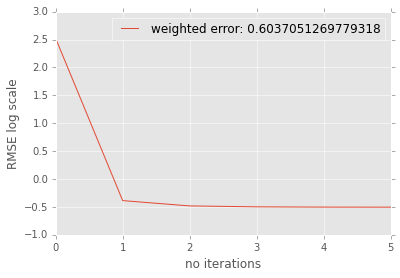

** Set weight:  0  to missing ratings **
** Surrogate missing rating values by imputation value:  0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.01
Impute value:  0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  12.872808488465616
ATOP  0.499047333061  RMSE (TEST)  11.608959898403306
1th iteration is completed
RMSE (TRAIN)  0.4206620703543377
ATOP  0.663246581496  RMSE (TEST)  1.0400693419062554
2th iteration is completed
RMSE (TRAIN)  0.33077979575884914
ATOP  0.720142463394  RMSE (TEST)  0.9991219604791128
3th iteration is completed
RMSE (TRAIN)  0.3061070387024807
ATOP  0.738496422966  RMSE (TEST)  0.9865976764790538
4th iteration is completed
RMSE (TRAIN)  0.2943

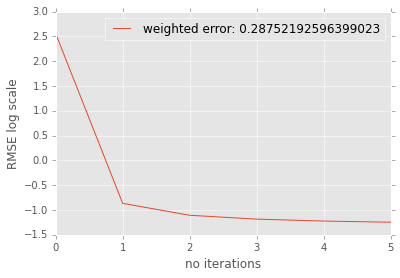

** Set weight:  0.02  to missing ratings **
** Surrogate missing rating values by imputation value:  0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.01
Impute value:  0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  12.825534311946585
ATOP  0.48638033271  RMSE (TEST)  11.582058065442357
1th iteration is completed
RMSE (TRAIN)  0.4810124482623575
ATOP  0.596640097025  RMSE (TEST)  1.0224899174187339
2th iteration is completed
RMSE (TRAIN)  0.36898870289980334
ATOP  0.681090190093  RMSE (TEST)  0.9794533829680779
3th iteration is completed
RMSE (TRAIN)  0.3477281873940426
ATOP  0.695933755214  RMSE (TEST)  0.9702797926707661
4th iteration is completed
RMSE (TRAIN)  0.3

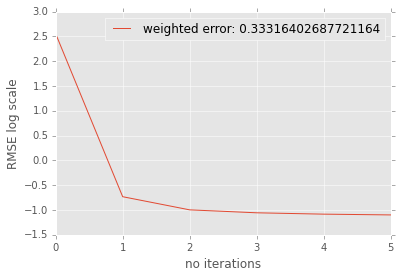

** Set weight:  0  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.02
Impute value:  -0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  11.83103952172732
ATOP  0.504066272566  RMSE (TEST)  11.59696769772226
1th iteration is completed
RMSE (TRAIN)  0.46341872744851637
ATOP  0.78471484245  RMSE (TEST)  0.3376817206745051
2th iteration is completed
RMSE (TRAIN)  0.36883799168733294
ATOP  0.831635027672  RMSE (TEST)  0.2743429938139748
3th iteration is completed
RMSE (TRAIN)  0.33782639887555604
ATOP  0.849794219976  RMSE (TEST)  0.2624480955098279
4th iteration is completed
RMSE (TRAIN)  0.324

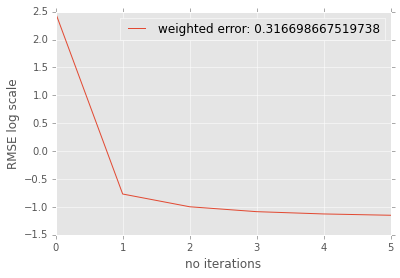

** Set weight:  0.02  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.02
Impute value:  -0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  11.867231204717323
ATOP  0.508179069817  RMSE (TEST)  11.62631286015971
1th iteration is completed
RMSE (TRAIN)  0.5765750006567419
ATOP  0.891661763865  RMSE (TEST)  0.5095081232322635
2th iteration is completed
RMSE (TRAIN)  0.4286714455851628
ATOP  0.92217167832  RMSE (TEST)  0.340509412978998
3th iteration is completed
RMSE (TRAIN)  0.3949849382447456
ATOP  0.928445174343  RMSE (TEST)  0.31689123264992597
4th iteration is completed
RMSE (TRAIN)  0.3

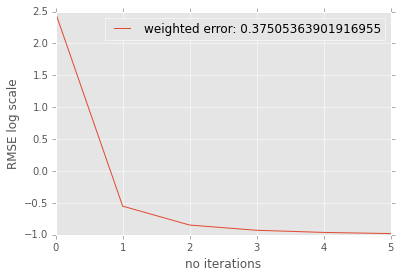

** Set weight:  0.05  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.02
Impute value:  -0.5
Weight:  0.05
*******************************
0th iteration is completed
RMSE (TRAIN)  11.911475785328873
ATOP  0.510873568157  RMSE (TEST)  11.649548262667086
1th iteration is completed
RMSE (TRAIN)  0.6737489991415982
ATOP  0.896971790434  RMSE (TEST)  0.6478316141239633
2th iteration is completed
RMSE (TRAIN)  0.48308747565584986
ATOP  0.932148050549  RMSE (TEST)  0.39234005434309865
3th iteration is completed
RMSE (TRAIN)  0.44897378879084043
ATOP  0.936941867151  RMSE (TEST)  0.3646598656604678
4th iteration is completed
RMSE (TRAIN)

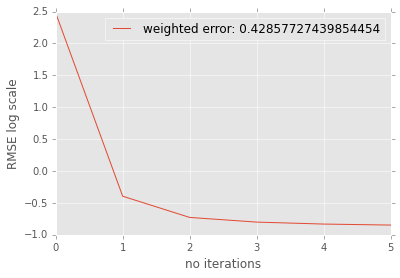

** Set weight:  0.08  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.02
Impute value:  -0.5
Weight:  0.08
*******************************
0th iteration is completed
RMSE (TRAIN)  11.843372694689307
ATOP  0.491465457351  RMSE (TEST)  11.56885161331792
1th iteration is completed
RMSE (TRAIN)  0.7345025012634133
ATOP  0.898203119335  RMSE (TEST)  0.7301133382282525
2th iteration is completed
RMSE (TRAIN)  0.5190816862747456
ATOP  0.933109455466  RMSE (TEST)  0.431473870754484
3th iteration is completed
RMSE (TRAIN)  0.48852630560623606
ATOP  0.937705707891  RMSE (TEST)  0.40316358864160473
4th iteration is completed
RMSE (TRAIN)  0

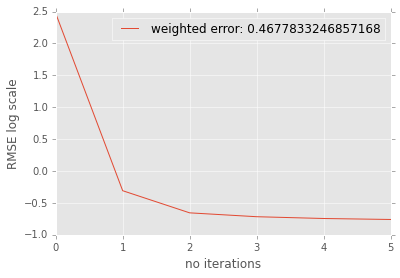

** Set weight:  0.1  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.02
Impute value:  -0.5
Weight:  0.1
*******************************
0th iteration is completed
RMSE (TRAIN)  11.835274341001993
ATOP  0.479499212565  RMSE (TEST)  11.512836739788726
1th iteration is completed
RMSE (TRAIN)  0.7573847373158429
ATOP  0.894429051334  RMSE (TEST)  0.7622065465047133
2th iteration is completed
RMSE (TRAIN)  0.5370190081073695
ATOP  0.932812086402  RMSE (TEST)  0.45271605414099253
3th iteration is completed
RMSE (TRAIN)  0.5088230112120784
ATOP  0.93765112078  RMSE (TEST)  0.42491313919366314
4th iteration is completed
RMSE (TRAIN)  0.

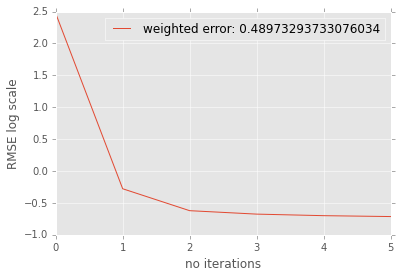

** Set weight:  0.3  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.02
Impute value:  -0.5
Weight:  0.3
*******************************
0th iteration is completed
RMSE (TRAIN)  11.860209394619147
ATOP  0.488414027744  RMSE (TEST)  11.535961506987055
1th iteration is completed
RMSE (TRAIN)  0.8797782877089558
ATOP  0.892578336135  RMSE (TEST)  0.92827408519468
2th iteration is completed
RMSE (TRAIN)  0.6556243187533234
ATOP  0.917530738459  RMSE (TEST)  0.612282382840912
3th iteration is completed
RMSE (TRAIN)  0.6311239945198663
ATOP  0.926560530029  RMSE (TEST)  0.5791683687261031
4th iteration is completed
RMSE (TRAIN)  0.6248

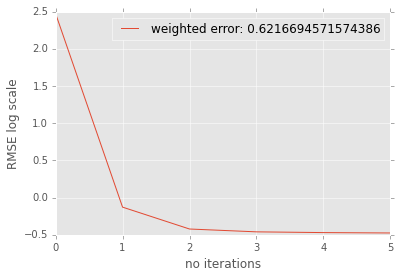

** Set weight:  0  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.02
Impute value:  -0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  12.367613420639646
ATOP  0.514315188908  RMSE (TEST)  11.635877113945083
1th iteration is completed
RMSE (TRAIN)  0.4747938738361991
ATOP  0.744695210536  RMSE (TEST)  0.8112782773677337
2th iteration is completed
RMSE (TRAIN)  0.35353771384865423
ATOP  0.824438576362  RMSE (TEST)  0.6073221711017883
3th iteration is completed
RMSE (TRAIN)  0.3278203273550653
ATOP  0.838937022902  RMSE (TEST)  0.5755786676080975
4th iteration is completed
RMSE (TRAIN)  0.3173951465915921
ATOP  0.843168572057  RMSE (TEST)  0.56125424002515

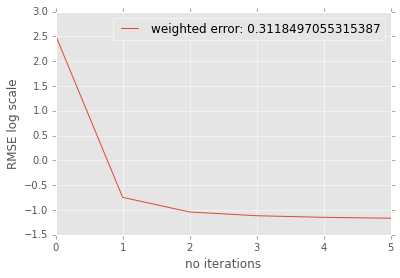

** Set weight:  0.02  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.02
Impute value:  -0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  12.332823686923831
ATOP  0.487923488745  RMSE (TEST)  11.52604038254006
1th iteration is completed
RMSE (TRAIN)  0.5280259890525671
ATOP  0.874035310449  RMSE (TEST)  0.8894169620647928
2th iteration is completed
RMSE (TRAIN)  0.39664330618697735
ATOP  0.921475942041  RMSE (TEST)  0.6689284654706045
3th iteration is completed
RMSE (TRAIN)  0.374840369065518
ATOP  0.926598941778  RMSE (TEST)  0.6492769294775174
4th iteration is completed
RMSE (TRAIN)  0.3671071777578041
ATOP  0.928161196358  RMSE (TEST)  0.642281259775

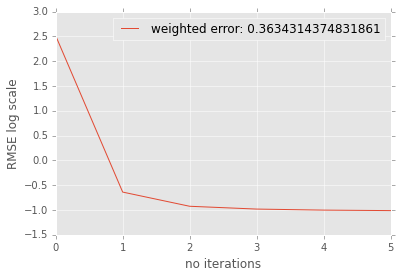

** Set weight:  0.05  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.02
Impute value:  -0.5
Weight:  0.05
*******************************
0th iteration is completed
RMSE (TRAIN)  12.35651193007591
ATOP  0.491367912721  RMSE (TEST)  11.592648060187386
1th iteration is completed
RMSE (TRAIN)  0.5577867789317748
ATOP  0.889294895522  RMSE (TEST)  0.9343647016632624
2th iteration is completed
RMSE (TRAIN)  0.44374774537203465
ATOP  0.929910597727  RMSE (TEST)  0.7227524611809429
3th iteration is completed
RMSE (TRAIN)  0.424088286473397
ATOP  0.935047127441  RMSE (TEST)  0.7077840094285885
4th iteration is completed
RMSE (TRAIN)  0.41600115700392154
ATOP  0.936240335016  RMSE (TEST)  0.70466295885

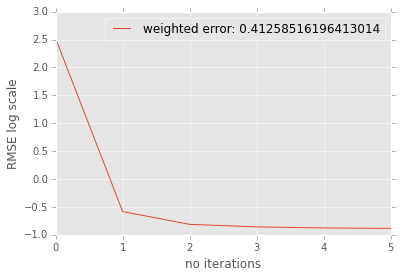

** Set weight:  0.08  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.02
Impute value:  -0.5
Weight:  0.08
*******************************
0th iteration is completed
RMSE (TRAIN)  12.327069990798336
ATOP  0.497837003089  RMSE (TEST)  11.566926179963511
1th iteration is completed
RMSE (TRAIN)  0.57324935901918
ATOP  0.888677295963  RMSE (TEST)  0.9592833003122583
2th iteration is completed
RMSE (TRAIN)  0.47570357738947666
ATOP  0.930456146845  RMSE (TEST)  0.7695103916536927
3th iteration is completed
RMSE (TRAIN)  0.4601942370361287
ATOP  0.93641174208  RMSE (TEST)  0.7549342145070683
4th iteration is completed
RMSE (TRAIN)  0.45331884688840135
ATOP  0.937859569549  RMSE (TEST)  0.753045765969

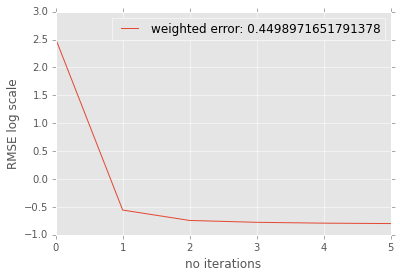

** Set weight:  0.1  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.02
Impute value:  -0.5
Weight:  0.1
*******************************
0th iteration is completed
RMSE (TRAIN)  12.32152882495289
ATOP  0.48767849073  RMSE (TEST)  11.554788810822982
1th iteration is completed
RMSE (TRAIN)  0.5815819933432912
ATOP  0.890591279429  RMSE (TEST)  0.9734142145859882
2th iteration is completed
RMSE (TRAIN)  0.49279200626429814
ATOP  0.929475195121  RMSE (TEST)  0.7971771073494659
3th iteration is completed
RMSE (TRAIN)  0.4794363962384392
ATOP  0.935780663053  RMSE (TEST)  0.7836051934399666
4th iteration is completed
RMSE (TRAIN)  0.4738431914103956
ATOP  0.937486248259  RMSE (TEST)  0.78196121056299

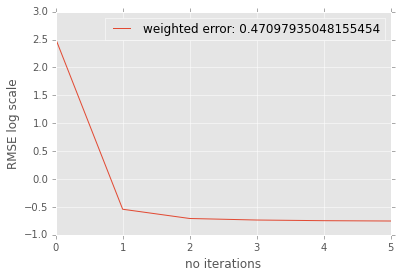

** Set weight:  0  to missing ratings **
** Surrogate missing rating values by imputation value:  0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.02
Impute value:  0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  12.882829769836977
ATOP  0.510054319542  RMSE (TEST)  11.651904839617005
1th iteration is completed
RMSE (TRAIN)  0.46470912456739827
ATOP  0.671343259248  RMSE (TEST)  1.0249068450892016
2th iteration is completed
RMSE (TRAIN)  0.35774143789863
ATOP  0.754507998211  RMSE (TEST)  0.9951377042596707
3th iteration is completed
RMSE (TRAIN)  0.33186145558707464
ATOP  0.775041363658  RMSE (TEST)  0.9819213685808102
4th iteration is completed
RMSE (TRAIN)  0.32082

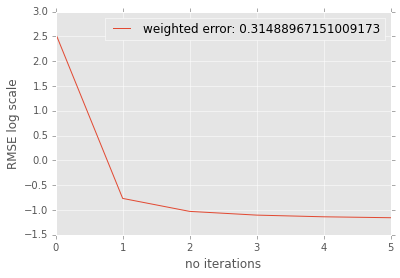

** Set weight:  0.02  to missing ratings **
** Surrogate missing rating values by imputation value:  0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.02
Impute value:  0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  12.83150189578948
ATOP  0.490111064378  RMSE (TEST)  11.549042875117724
1th iteration is completed
RMSE (TRAIN)  0.5252260081807975
ATOP  0.614391110829  RMSE (TEST)  1.0111674763846434
2th iteration is completed
RMSE (TRAIN)  0.4021989625398422
ATOP  0.703381448658  RMSE (TEST)  0.993284655121903
3th iteration is completed
RMSE (TRAIN)  0.3783713654556294
ATOP  0.719036282044  RMSE (TEST)  0.9804243142869484
4th iteration is completed
RMSE (TRAIN)  0.369

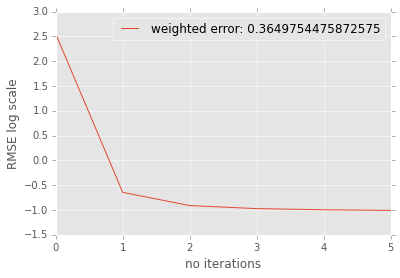

** Set weight:  0  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.03
Impute value:  -0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  11.811475603152749
ATOP  0.49459391249  RMSE (TEST)  11.578273333803313
1th iteration is completed
RMSE (TRAIN)  0.5091703543256939
ATOP  0.796783385982  RMSE (TEST)  0.3980979999366507
2th iteration is completed
RMSE (TRAIN)  0.4033711394258884
ATOP  0.851676622974  RMSE (TEST)  0.26173363207888445
3th iteration is completed
RMSE (TRAIN)  0.37074262792372287
ATOP  0.868002664427  RMSE (TEST)  0.24057832241118943
4th iteration is completed
RMSE (TRAIN)  0.3

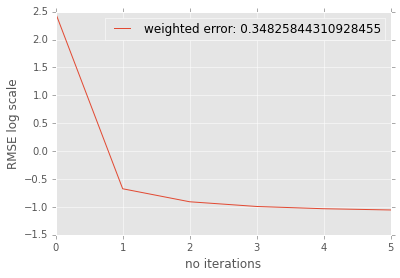

** Set weight:  0.02  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.03
Impute value:  -0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  11.830722467024826
ATOP  0.505178956892  RMSE (TEST)  11.568098949268927
1th iteration is completed
RMSE (TRAIN)  0.630473268133982
ATOP  0.893566466386  RMSE (TEST)  0.5812723065975569
2th iteration is completed
RMSE (TRAIN)  0.4618160082446058
ATOP  0.927080850128  RMSE (TEST)  0.33882390437167026
3th iteration is completed
RMSE (TRAIN)  0.43059583566525983
ATOP  0.933470452671  RMSE (TEST)  0.3078730513402684
4th iteration is completed
RMSE (TRAIN)  

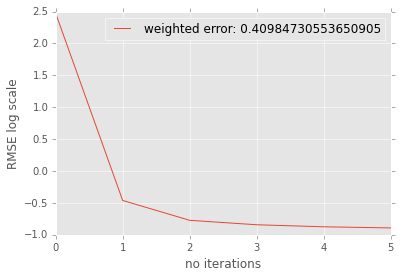

** Set weight:  0.05  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.03
Impute value:  -0.5
Weight:  0.05
*******************************
0th iteration is completed
RMSE (TRAIN)  11.851008851594722
ATOP  0.494069974716  RMSE (TEST)  11.566064782297913
1th iteration is completed
RMSE (TRAIN)  0.7179425656844528
ATOP  0.896308127081  RMSE (TEST)  0.705347032880116
2th iteration is completed
RMSE (TRAIN)  0.5128943203112997
ATOP  0.930422640739  RMSE (TEST)  0.40488680714313563
3th iteration is completed
RMSE (TRAIN)  0.4858917252700167
ATOP  0.935567737964  RMSE (TEST)  0.37260730063517583
4th iteration is completed
RMSE (TRAIN)  

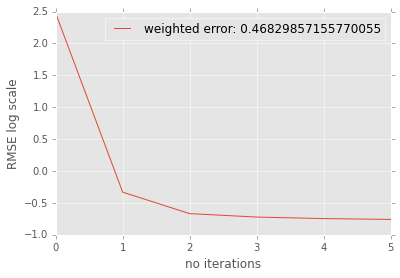

** Set weight:  0.08  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.03
Impute value:  -0.5
Weight:  0.08
*******************************
0th iteration is completed
RMSE (TRAIN)  11.914848374197456
ATOP  0.516314020419  RMSE (TEST)  11.698966453802754
1th iteration is completed
RMSE (TRAIN)  0.7793562065506915
ATOP  0.895571838753  RMSE (TEST)  0.79037460986904
2th iteration is completed
RMSE (TRAIN)  0.547371572472434
ATOP  0.928431833774  RMSE (TEST)  0.45309767020385394
3th iteration is completed
RMSE (TRAIN)  0.5218977996856827
ATOP  0.933624175431  RMSE (TEST)  0.42068621835866155
4th iteration is completed
RMSE (TRAIN)  0.

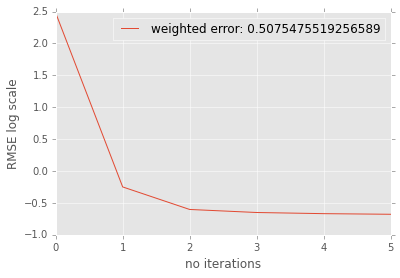

** Set weight:  0  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.03
Impute value:  -0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  12.333609755099417
ATOP  0.508431631487  RMSE (TEST)  11.638787145379585
1th iteration is completed
RMSE (TRAIN)  0.5000356433547318
ATOP  0.747657814552  RMSE (TEST)  0.8392937625577119
2th iteration is completed
RMSE (TRAIN)  0.38245384243340735
ATOP  0.844523981514  RMSE (TEST)  0.6018862969111859
3th iteration is completed
RMSE (TRAIN)  0.35909783176206234
ATOP  0.856465647578  RMSE (TEST)  0.5721754785323699
4th iteration is completed
RMSE (TRAIN)  0.34893804583870225
ATOP  0.859527961777  RMSE (TEST)  0.559672330359

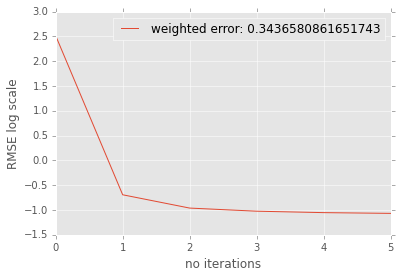

** Set weight:  0.02  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.03
Impute value:  -0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  12.39776698167604
ATOP  0.493290255352  RMSE (TEST)  11.600895265176986
1th iteration is completed
RMSE (TRAIN)  0.5485634181266104
ATOP  0.876355691989  RMSE (TEST)  0.9169836042095375
2th iteration is completed
RMSE (TRAIN)  0.429643169815338
ATOP  0.922223316995  RMSE (TEST)  0.6749674466152921
3th iteration is completed
RMSE (TRAIN)  0.412049389454854
ATOP  0.929510797332  RMSE (TEST)  0.653457904057679
4th iteration is completed
RMSE (TRAIN)  0.4041831416225419
ATOP  0.93123383324  RMSE (TEST)  0.647277460384497


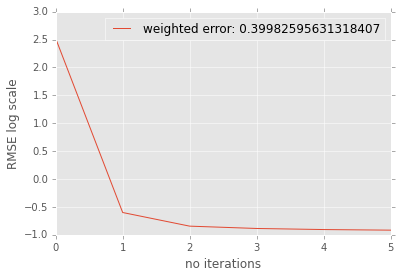

** Set weight:  0.05  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.03
Impute value:  -0.5
Weight:  0.05
*******************************
0th iteration is completed
RMSE (TRAIN)  12.369928289760951
ATOP  0.501067024601  RMSE (TEST)  11.607205649137669
1th iteration is completed
RMSE (TRAIN)  0.5700034141179386
ATOP  0.890984892528  RMSE (TEST)  0.9492863284290078
2th iteration is completed
RMSE (TRAIN)  0.4731661119823961
ATOP  0.923863430498  RMSE (TEST)  0.7467330439570813
3th iteration is completed
RMSE (TRAIN)  0.4605430915686098
ATOP  0.931491609918  RMSE (TEST)  0.7292770290358714
4th iteration is completed
RMSE (TRAIN)  0.45564369630807794
ATOP  0.933649549661  RMSE (TEST)  0.7249899901

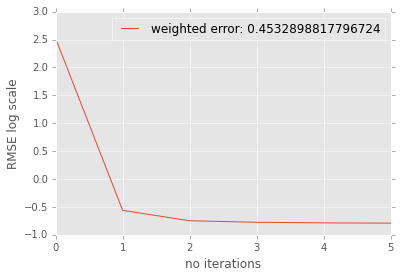

** Set weight:  0.08  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.03
Impute value:  -0.5
Weight:  0.08
*******************************
0th iteration is completed
RMSE (TRAIN)  12.351701513352568
ATOP  0.515661443692  RMSE (TEST)  11.647128883817848
1th iteration is completed
RMSE (TRAIN)  0.5827724411772596
ATOP  0.889903334093  RMSE (TEST)  0.971073799083993
2th iteration is completed
RMSE (TRAIN)  0.5054736276662605
ATOP  0.920054871474  RMSE (TEST)  0.8075460078306876
3th iteration is completed
RMSE (TRAIN)  0.4931571497193106
ATOP  0.929257585364  RMSE (TEST)  0.7889596446817223
4th iteration is completed
RMSE (TRAIN)  0.4900422389241303
ATOP  0.931530299464  RMSE (TEST)  0.786136760839

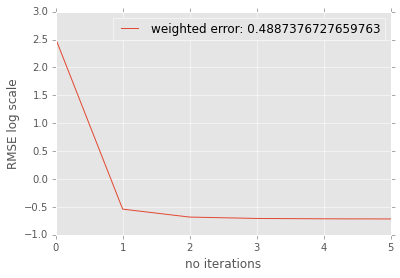

** Set weight:  0  to missing ratings **
** Surrogate missing rating values by imputation value:  0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.03
Impute value:  0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  12.968856970925803
ATOP  0.52023620473  RMSE (TEST)  11.748422415375611
1th iteration is completed
RMSE (TRAIN)  0.49344520191914315
ATOP  0.69181316702  RMSE (TEST)  1.0203682034242405
2th iteration is completed
RMSE (TRAIN)  0.38817207076660076
ATOP  0.780636327875  RMSE (TEST)  1.0069352933622375
3th iteration is completed
RMSE (TRAIN)  0.36232696607627984
ATOP  0.800910155159  RMSE (TEST)  0.9895549879310604
4th iteration is completed
RMSE (TRAIN)  0.3517

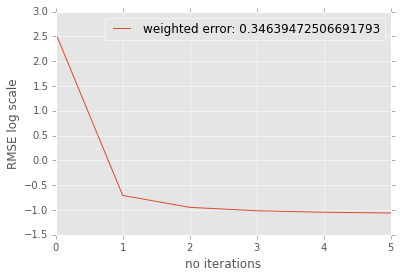

** Set weight:  0.02  to missing ratings **
** Surrogate missing rating values by imputation value:  0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.03
Impute value:  0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  12.825931557080079
ATOP  0.498472981445  RMSE (TEST)  11.58537625437751
1th iteration is completed
RMSE (TRAIN)  0.5416954048848637
ATOP  0.604431343285  RMSE (TEST)  1.0148499246242575
2th iteration is completed
RMSE (TRAIN)  0.43669066799331174
ATOP  0.71740503279  RMSE (TEST)  1.0112071330366978
3th iteration is completed
RMSE (TRAIN)  0.4171637679066794
ATOP  0.734299383774  RMSE (TEST)  0.9947009275649551
4th iteration is completed
RMSE (TRAIN)  0.40

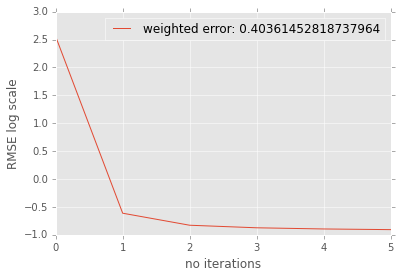

** Set weight:  0  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.04
Impute value:  -0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  11.834518696082252
ATOP  0.503191281457  RMSE (TEST)  11.587053609495548
1th iteration is completed
RMSE (TRAIN)  0.5500967029187095
ATOP  0.806849410879  RMSE (TEST)  0.4547906268071745
2th iteration is completed
RMSE (TRAIN)  0.4305343746906285
ATOP  0.855483155343  RMSE (TEST)  0.26412306047066153
3th iteration is completed
RMSE (TRAIN)  0.40038460927542946
ATOP  0.871360687221  RMSE (TEST)  0.23556514201305026
4th iteration is completed
RMSE (TRAIN)  0.

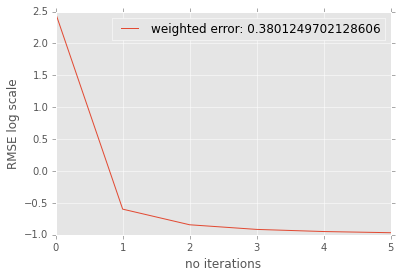

** Set weight:  0.02  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.04
Impute value:  -0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  11.866380058562381
ATOP  0.512226111254  RMSE (TEST)  11.661205210199403
1th iteration is completed
RMSE (TRAIN)  0.6732650731004604
ATOP  0.890281567339  RMSE (TEST)  0.6390382606053485
2th iteration is completed
RMSE (TRAIN)  0.483433237777249
ATOP  0.925274033169  RMSE (TEST)  0.3480729725308752
3th iteration is completed
RMSE (TRAIN)  0.4564030871966869
ATOP  0.931036010207  RMSE (TEST)  0.31333657549141686
4th iteration is completed
RMSE (TRAIN)  0

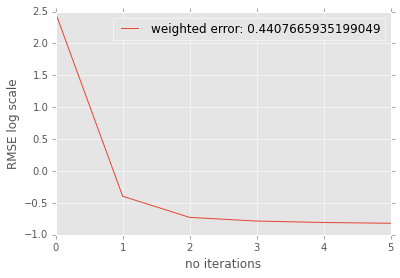

** Set weight:  0.05  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.04
Impute value:  -0.5
Weight:  0.05
*******************************
0th iteration is completed
RMSE (TRAIN)  11.856523645531418
ATOP  0.494196252395  RMSE (TEST)  11.613933728731737
1th iteration is completed
RMSE (TRAIN)  0.7582057116663081
ATOP  0.895421493753  RMSE (TEST)  0.7603178028393537
2th iteration is completed
RMSE (TRAIN)  0.5312385585939301
ATOP  0.924618785803  RMSE (TEST)  0.42191593273748695
3th iteration is completed
RMSE (TRAIN)  0.5068100287363233
ATOP  0.930039836469  RMSE (TEST)  0.3883934174599236
4th iteration is completed
RMSE (TRAIN)  

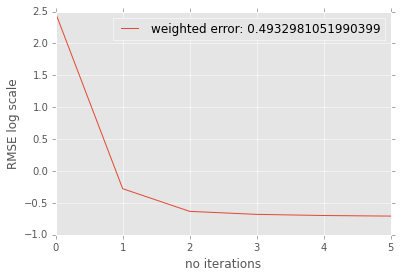

** Set weight:  0  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.04
Impute value:  -0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  12.362745065678318
ATOP  0.505699965171  RMSE (TEST)  11.618067880823547
1th iteration is completed
RMSE (TRAIN)  0.5233416799867834
ATOP  0.759000120955  RMSE (TEST)  0.87484423236076
2th iteration is completed
RMSE (TRAIN)  0.4060352971243779
ATOP  0.848617244585  RMSE (TEST)  0.6037546168410958
3th iteration is completed
RMSE (TRAIN)  0.38837500451575646
ATOP  0.860092508422  RMSE (TEST)  0.5761455629602339
4th iteration is completed
RMSE (TRAIN)  0.3804541311905815
ATOP  0.863797120859  RMSE (TEST)  0.5656149372693456

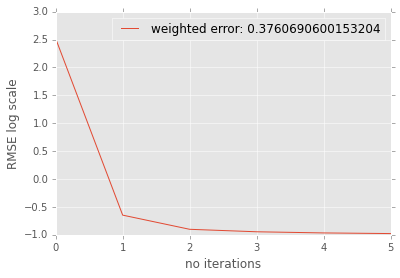

** Set weight:  0.02  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.04
Impute value:  -0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  12.45285781014997
ATOP  0.518350676516  RMSE (TEST)  11.746614654669434
1th iteration is completed
RMSE (TRAIN)  0.562696508557969
ATOP  0.882251945996  RMSE (TEST)  0.9360464622387596
2th iteration is completed
RMSE (TRAIN)  0.44903004727094803
ATOP  0.9160656055  RMSE (TEST)  0.6887700856056388
3th iteration is completed
RMSE (TRAIN)  0.43747955184331583
ATOP  0.924470934662  RMSE (TEST)  0.6697673423928796
4th iteration is completed
RMSE (TRAIN)  0.4329979002185683
ATOP  0.927012613082  RMSE (TEST)  0.6641670277717

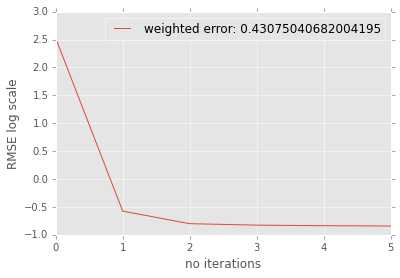

** Set weight:  0.05  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.04
Impute value:  -0.5
Weight:  0.05
*******************************
0th iteration is completed
RMSE (TRAIN)  12.338780869436766
ATOP  0.491035976871  RMSE (TEST)  11.5715693751616
1th iteration is completed
RMSE (TRAIN)  0.578980049636048
ATOP  0.891286112868  RMSE (TEST)  0.9623101213807005
2th iteration is completed
RMSE (TRAIN)  0.4902922371714523
ATOP  0.915225225372  RMSE (TEST)  0.7713323705435118
3th iteration is completed
RMSE (TRAIN)  0.4800650400321745
ATOP  0.924017026986  RMSE (TEST)  0.7557168843421779
4th iteration is completed
RMSE (TRAIN)  0.47745380152126654
ATOP  0.926413745881  RMSE (TEST)  0.7527229146911

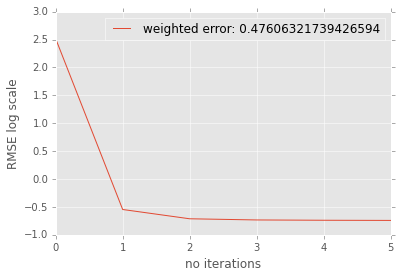

** Set weight:  0  to missing ratings **
** Surrogate missing rating values by imputation value:  0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.04
Impute value:  0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  12.841190372306386
ATOP  0.501179128318  RMSE (TEST)  11.583648367793037
1th iteration is completed
RMSE (TRAIN)  0.5078989048276655
ATOP  0.690892762415  RMSE (TEST)  1.021782875804962
2th iteration is completed
RMSE (TRAIN)  0.4150117983771328
ATOP  0.795892453113  RMSE (TEST)  1.0227086379693304
3th iteration is completed
RMSE (TRAIN)  0.3934452602234582
ATOP  0.814252555786  RMSE (TEST)  1.0009437424954297
4th iteration is completed
RMSE (TRAIN)  0.384167

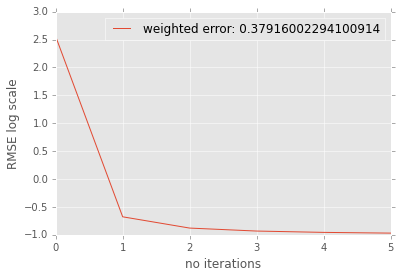

** Set weight:  0.02  to missing ratings **
** Surrogate missing rating values by imputation value:  0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.04
Impute value:  0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  12.887588427256599
ATOP  0.491766829217  RMSE (TEST)  11.633066560085691
1th iteration is completed
RMSE (TRAIN)  0.554804243291185
ATOP  0.629467311999  RMSE (TEST)  1.0090813950344142
2th iteration is completed
RMSE (TRAIN)  0.45679639096287766
ATOP  0.706859277723  RMSE (TEST)  1.0333120731327359
3th iteration is completed
RMSE (TRAIN)  0.44442039452682386
ATOP  0.728052297407  RMSE (TEST)  1.012121687427511
4th iteration is completed
RMSE (TRAIN)  0.4

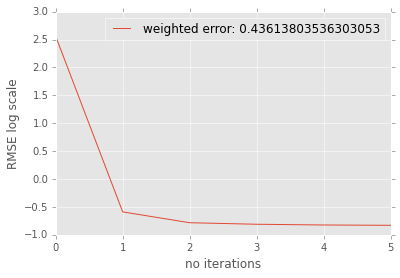

** Set weight:  0  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.05
Impute value:  -0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  11.821556013958846
ATOP  0.504678152032  RMSE (TEST)  11.610539997960183
1th iteration is completed
RMSE (TRAIN)  0.5834871535003034
ATOP  0.803875095194  RMSE (TEST)  0.5006427532346854
2th iteration is completed
RMSE (TRAIN)  0.4488819257861222
ATOP  0.851773353153  RMSE (TEST)  0.27078849852189796
3th iteration is completed
RMSE (TRAIN)  0.4219252801953516
ATOP  0.864894570545  RMSE (TEST)  0.2375418445502935
4th iteration is completed
RMSE (TRAIN)  0.41

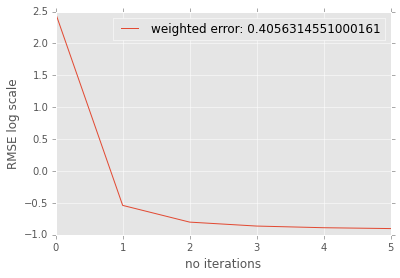

** Set weight:  0.02  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.05
Impute value:  -0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  11.816318317932758
ATOP  0.495523642236  RMSE (TEST)  11.555541903983972
1th iteration is completed
RMSE (TRAIN)  0.7057858019508689
ATOP  0.892701595927  RMSE (TEST)  0.6847394143172715
2th iteration is completed
RMSE (TRAIN)  0.4980952267680823
ATOP  0.920276723949  RMSE (TEST)  0.36056003106840756
3th iteration is completed
RMSE (TRAIN)  0.4724295683124672
ATOP  0.925782578464  RMSE (TEST)  0.3242689883452943
4th iteration is completed
RMSE (TRAIN)  

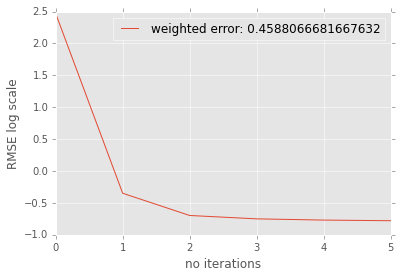

** Set weight:  0.05  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.05
Impute value:  -0.5
Weight:  0.05
*******************************
0th iteration is completed
RMSE (TRAIN)  11.870057825967482
ATOP  0.506124230643  RMSE (TEST)  11.6112072694994
1th iteration is completed
RMSE (TRAIN)  0.7827360387881158
ATOP  0.893822058569  RMSE (TEST)  0.7940969406314454
2th iteration is completed
RMSE (TRAIN)  0.5485682360113789
ATOP  0.915207547381  RMSE (TEST)  0.4428421501147314
3th iteration is completed
RMSE (TRAIN)  0.5230591637177082
ATOP  0.923142105327  RMSE (TEST)  0.4067301314621127
4th iteration is completed
RMSE (TRAIN)  0.5

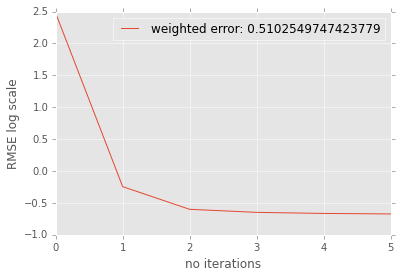

** Set weight:  0  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.05
Impute value:  -0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  12.316296874998589
ATOP  0.497711085284  RMSE (TEST)  11.575723353264387
1th iteration is completed
RMSE (TRAIN)  0.5355189147631807
ATOP  0.770076076856  RMSE (TEST)  0.8905358273765986
2th iteration is completed
RMSE (TRAIN)  0.4212169401334936
ATOP  0.843447417112  RMSE (TEST)  0.6087137265606886
3th iteration is completed
RMSE (TRAIN)  0.4103095312488316
ATOP  0.852521814041  RMSE (TEST)  0.5861403853045057
4th iteration is completed
RMSE (TRAIN)  0.4051084682279166
ATOP  0.857586419585  RMSE (TEST)  0.577448199430647

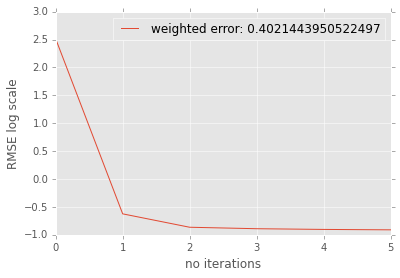

** Set weight:  0.02  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.05
Impute value:  -0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  12.334765029624137
ATOP  0.491936039159  RMSE (TEST)  11.533048481428088
1th iteration is completed
RMSE (TRAIN)  0.5709431144290054
ATOP  0.886628258958  RMSE (TEST)  0.947327196499303
2th iteration is completed
RMSE (TRAIN)  0.46126442749607977
ATOP  0.909379681945  RMSE (TEST)  0.7031733283532658
3th iteration is completed
RMSE (TRAIN)  0.4523793786220936
ATOP  0.917920279306  RMSE (TEST)  0.6887469981799323
4th iteration is completed
RMSE (TRAIN)  0.4492825393253223
ATOP  0.920726647762  RMSE (TEST)  0.68464746090

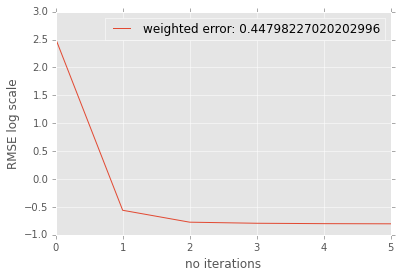

** Set weight:  0.05  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.05
Impute value:  -0.5
Weight:  0.05
*******************************
0th iteration is completed
RMSE (TRAIN)  12.383418018160528
ATOP  0.509270824664  RMSE (TEST)  11.635035679344133
1th iteration is completed
RMSE (TRAIN)  0.5848390728020676
ATOP  0.889990941166  RMSE (TEST)  0.970095511827459
2th iteration is completed
RMSE (TRAIN)  0.5079773933446368
ATOP  0.903974194224  RMSE (TEST)  0.8015947554712266
3th iteration is completed
RMSE (TRAIN)  0.4943086015281778
ATOP  0.916538820067  RMSE (TEST)  0.7811079710527474
4th iteration is completed
RMSE (TRAIN)  0.49082671438692305
ATOP  0.91989431112  RMSE (TEST)  0.776122953681

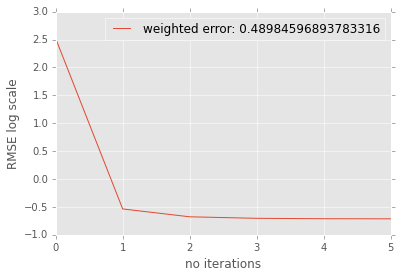

** Set weight:  0  to missing ratings **
** Surrogate missing rating values by imputation value:  0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.05
Impute value:  0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  12.83748002626716
ATOP  0.489892318179  RMSE (TEST)  11.566074015322899
1th iteration is completed
RMSE (TRAIN)  0.5285026326461271
ATOP  0.706176288538  RMSE (TEST)  1.0149964640776603
2th iteration is completed
RMSE (TRAIN)  0.431718761899123
ATOP  0.79526775079  RMSE (TEST)  1.039541277092516
3th iteration is completed
RMSE (TRAIN)  0.4166135005955969
ATOP  0.81348005283  RMSE (TEST)  1.014242073435684
4th iteration is completed
RMSE (TRAIN)  0.40973739963

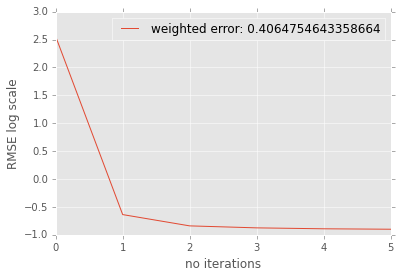

** Set weight:  0.02  to missing ratings **
** Surrogate missing rating values by imputation value:  0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.05
Impute value:  0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  12.887510049160516
ATOP  0.506737164475  RMSE (TEST)  11.651735147214751
1th iteration is completed
RMSE (TRAIN)  0.5662446745169382
ATOP  0.624266775331  RMSE (TEST)  1.0071763468003434
2th iteration is completed
RMSE (TRAIN)  0.46760391096032144
ATOP  0.702923626571  RMSE (TEST)  1.047310966423566
3th iteration is completed
RMSE (TRAIN)  0.45863088251696515
ATOP  0.720555282367  RMSE (TEST)  1.025099305226941
4th iteration is completed
RMSE (TRAIN)  0.4

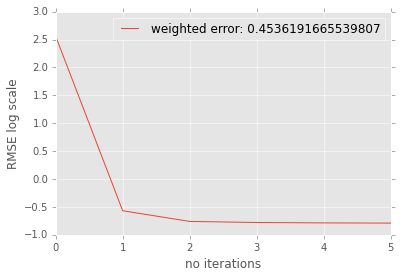

** Set weight:  0  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.06
Impute value:  -0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  11.856182546332747
ATOP  0.49365311506  RMSE (TEST)  11.594610435386533
1th iteration is completed
RMSE (TRAIN)  0.6108781552000747
ATOP  0.815484547611  RMSE (TEST)  0.5403443317833572
2th iteration is completed
RMSE (TRAIN)  0.459500873552552
ATOP  0.847221826046  RMSE (TEST)  0.2762886944934056
3th iteration is completed
RMSE (TRAIN)  0.43501546639590727
ATOP  0.856632066924  RMSE (TEST)  0.24215139804919583
4th iteration is completed
RMSE (TRAIN)  0.425

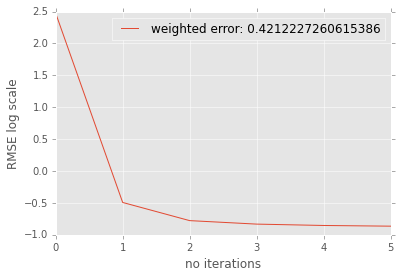

** Set weight:  0.02  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.06
Impute value:  -0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  11.825250059498565
ATOP  0.51404557429  RMSE (TEST)  11.62097409816479
1th iteration is completed
RMSE (TRAIN)  0.7291861142610516
ATOP  0.8916863489  RMSE (TEST)  0.715863418213825
2th iteration is completed
RMSE (TRAIN)  0.5097220894454527
ATOP  0.91361202661  RMSE (TEST)  0.37299961870924725
3th iteration is completed
RMSE (TRAIN)  0.48421673487248407
ATOP  0.920215444455  RMSE (TEST)  0.3364146521675613
4th iteration is completed
RMSE (TRAIN)  0.475

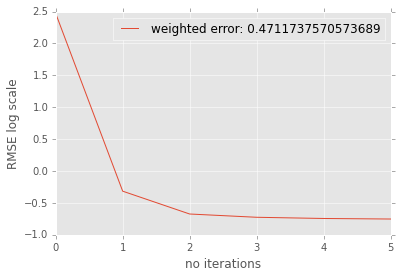

** Set weight:  0.05  to missing ratings **
** Surrogate missing rating values by imputation value:  -0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.06
Impute value:  -0.5
Weight:  0.05
*******************************
0th iteration is completed
RMSE (TRAIN)  11.835842533869169
ATOP  0.49712472526  RMSE (TEST)  11.541369994815552
1th iteration is completed
RMSE (TRAIN)  0.8034857456497552
ATOP  0.894101440278  RMSE (TEST)  0.8220849118441697
2th iteration is completed
RMSE (TRAIN)  0.5572023397639742
ATOP  0.907877810332  RMSE (TEST)  0.45394410103481947
3th iteration is completed
RMSE (TRAIN)  0.536173169442729
ATOP  0.916532500185  RMSE (TEST)  0.4239727904078903
4th iteration is completed
RMSE (TRAIN)  0.

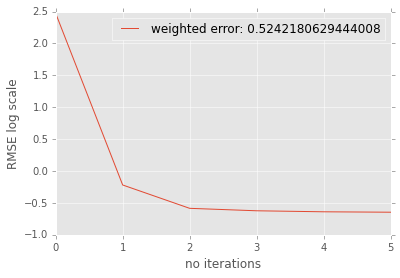

** Set weight:  0  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.06
Impute value:  -0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  12.37904323861754
ATOP  0.516684929926  RMSE (TEST)  11.700050554578288
1th iteration is completed
RMSE (TRAIN)  0.5501206581951734
ATOP  0.782981123984  RMSE (TEST)  0.9128409588627536
2th iteration is completed
RMSE (TRAIN)  0.43189543793872515
ATOP  0.837326280118  RMSE (TEST)  0.612666026870471
3th iteration is completed
RMSE (TRAIN)  0.42388058600878176
ATOP  0.844042799225  RMSE (TEST)  0.5967492689235817
4th iteration is completed
RMSE (TRAIN)  0.42033666638149825
ATOP  0.849163608153  RMSE (TEST)  0.59076409563411

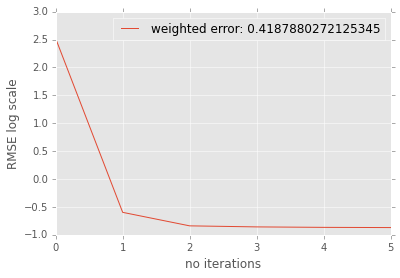

** Set weight:  0.02  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.06
Impute value:  -0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  12.363681907708127
ATOP  0.49852203787  RMSE (TEST)  11.625392023431168
1th iteration is completed
RMSE (TRAIN)  0.5769954752158518
ATOP  0.885195325197  RMSE (TEST)  0.9562778338746182
2th iteration is completed
RMSE (TRAIN)  0.47226104830127313
ATOP  0.902197814978  RMSE (TEST)  0.7204905488056731
3th iteration is completed
RMSE (TRAIN)  0.4635731319394795
ATOP  0.911117706264  RMSE (TEST)  0.7079918482752889
4th iteration is completed
RMSE (TRAIN)  0.46047628991399825
ATOP  0.914754611995  RMSE (TEST)  0.7043096364

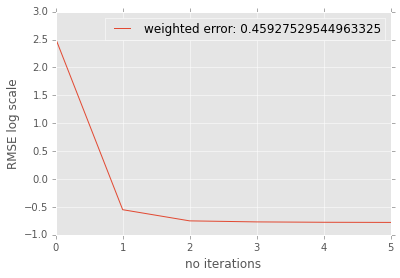

** Set weight:  0.05  to missing ratings **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.06
Impute value:  -0.5
Weight:  0.05
*******************************
0th iteration is completed
RMSE (TRAIN)  12.2837431067286
ATOP  0.500956309868  RMSE (TEST)  11.544846573329082
1th iteration is completed
RMSE (TRAIN)  0.5880823068097843
ATOP  0.892173964716  RMSE (TEST)  0.9744116869973376
2th iteration is completed
RMSE (TRAIN)  0.5192897601138785
ATOP  0.899556502136  RMSE (TEST)  0.8241393684763256
3th iteration is completed
RMSE (TRAIN)  0.5061129880436055
ATOP  0.908788182677  RMSE (TEST)  0.8037541666676125
4th iteration is completed
RMSE (TRAIN)  0.5025502044163352
ATOP  0.912525972915  RMSE (TEST)  0.7985418288848

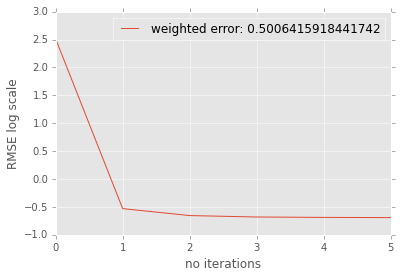

** Set weight:  0  to missing ratings **
** Surrogate missing rating values by imputation value:  0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.06
Impute value:  0.5
Weight:  0.0
*******************************
0th iteration is completed
RMSE (TRAIN)  12.893098154890584
ATOP  0.50594229886  RMSE (TEST)  11.6813419683414
1th iteration is completed
RMSE (TRAIN)  0.5384909863379544
ATOP  0.714214136461  RMSE (TEST)  1.012323252880514
2th iteration is completed
RMSE (TRAIN)  0.44314514796011467
ATOP  0.791889650848  RMSE (TEST)  1.052437567781277
3th iteration is completed
RMSE (TRAIN)  0.4316765076805133
ATOP  0.807436610607  RMSE (TEST)  1.026087304635054
4th iteration is completed
RMSE (TRAIN)  0.4265989155

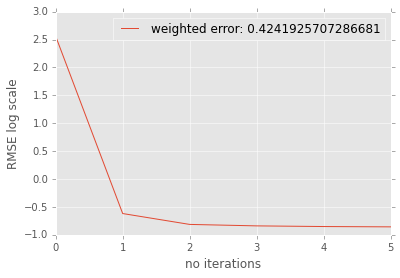

** Set weight:  0.02  to missing ratings **
** Surrogate missing rating values by imputation value:  0.5  **
Item range [range(0, 529), range(529, 1058), range(1058, 1587), range(1587, 2116), range(2116, 2645), range(2645, 3174), range(3174, 3698)]
User range [range(0, 777), range(777, 1554), range(1554, 2331), range(2331, 3108), range(3108, 3885), range(3885, 4662), range(4662, 5436)]
*******************************
Lambda:  0.06
Impute value:  0.5
Weight:  0.02
*******************************
0th iteration is completed
RMSE (TRAIN)  12.864365813965428
ATOP  0.503097442892  RMSE (TEST)  11.638975354819667
1th iteration is completed
RMSE (TRAIN)  0.5717414859163975
ATOP  0.643942051091  RMSE (TEST)  1.006403851546069
2th iteration is completed
RMSE (TRAIN)  0.47468510179127976
ATOP  0.694940959235  RMSE (TEST)  1.0513447547475439
3th iteration is completed
RMSE (TRAIN)  0.46974380202169147
ATOP  0.712435168651  RMSE (TEST)  1.0361032070094638
4th iteration is completed
RMSE (TRAIN)  0.

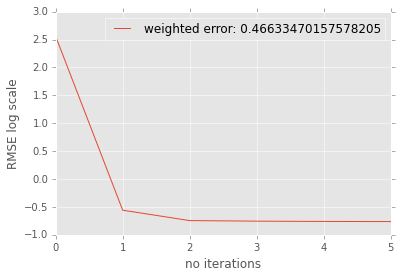

In [43]:
ATOPs = {}
for lambda_ in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]:
    ATOPs[lambda_] = {}
    for impute in [-0.5, 0, 0.5]:
        ATOPs[lambda_][impute] = []
        for weight in [0, 0.02, 0.05, 0.08,  0.1, 0.3, 0.5, 0.8, 1]:
            ATOP = MFact.optimaze(6, opt_method="solver",  lambda_ = lambda_, no_process = 7, weights_mode = "AllRank", weight = weight, opt_lin = True, imputation_value = impute , random_init = True, sparse = True, beta= 0.0, K = 20)
            if(ATOPs[lambda_][impute]==[]):
                 ATOPs[lambda_][impute].append(ATOP)
            else:
                if(ATOPs[lambda_][impute][-1]>ATOP):
                    ATOPs[lambda_][impute].append(ATOP)
                    break
                else:
                    ATOPs[lambda_][impute].append(ATOP)
# start_time = datetime.datetime.now()
# datetime.datetime.now() - start_time

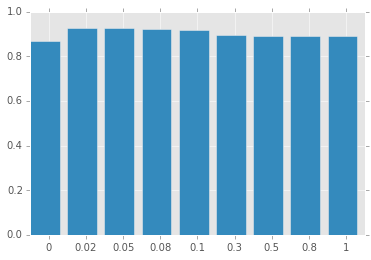

In [37]:
plt.bar(range(len(ATOPs)),ATOPs)
plt.xticks(np.arange(len(ATOPs))+0.5, [0, 0.02, 0.05, 0.08,  0.1, 0.3, 0.5, 0.8, 1])
plt.show()

In [51]:
for key in ATOPs.keys():
    print("lambda: ", key)
    for im in ATOPs[key].keys():
        print("     impute value: ", im)
        print("                  ", ATOPs[key][im])

lambda:  0.03
     impute value:  -0.5
                   [0.87336074356357907, 0.93502373567039399, 0.93726029827897539, 0.93520224549883313]
     impute value:  0
                   [0.86064136585007867, 0.93184326304197895, 0.9345076898566681, 0.93245310322548958]
     impute value:  0.5
                   [0.80954426277909464, 0.74155971576770352]
lambda:  0.04
     impute value:  -0.5
                   [0.87623523542077453, 0.93239542246604201, 0.93165237861978822]
     impute value:  0
                   [0.86517507606807986, 0.92802589659014156, 0.92751320959471961]
     impute value:  0.5
                   [0.82064403345893167, 0.73891840292634392]
lambda:  0.06
     impute value:  -0.5
                   [0.86079381326881965, 0.92210189445054913, 0.9203290129207049]
     impute value:  0
                   [0.85160998326159409, 0.91617770921747754, 0.91456074756890704]
     impute value:  0.5
                   [0.81612866415666974, 0.71995746953144579]
lambda:  0.05
     im